<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Py_trodes/PyTrodes_Pipeline_h5py_171.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
""" CONFIGURE """

import h5py
import numpy as np
import os
import tempfile
import urllib
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
from tqdm import tqdm
import subprocess

response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
%run Load_FS6.py
trodes_dat_reader_loc = 'C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\0_Projects\\LFP_Refactor\\Trodes_2-5-1_Windows64\\Resources\\TrodesToPython'
os.chdir(trodes_dat_reader_loc)
import readTrodesExtractedDataFile3 as trodes



In [2]:


def axm(ch):
    return  ch%8, 3-(ch//8)
def rip_hist(ripple_df_list):
    fig,ax = plt.subplots(8,4,figsize=(3,6))
    for ch,rip_df in enumerate(ripple_df_list):
        count,edges = np.histogram(rip_df['ripple_sd_max'],bins=np.logspace(1,4,20,base=2))
        ax[axm(ch)].stairs(count/np.sum(count),edges,linewidth=.4,color='k')
    plt.tight_layout()
    return fig,ax


def read_npy_metadata(npy_filename):
    with open(npy_filename, 'rb') as f:
        version = np.lib.format.read_magic(f)
        np.lib.format._check_version(version)
        shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(f)
        offset = f.tell()
    return shape, dtype, offset

def load_npy_to_memmap(npy_filename):
    shape, dtype, offset = read_npy_metadata(npy_filename)
    print(f'Loading {dtype} array shape:{shape}...')
    with open(npy_filename, 'rb') as f:
        array = np.memmap(f, dtype=dtype, mode='r+', offset=offset, shape=shape)
    print('     complete.')
    return array

def display_filter(fir_coeff,rate):
    # Plot the frequency response of the filter
    w, h = sci.signal.freqz(fir_coeff, worN=8000)
    fig,ax=plt.subplots(1,2,figsize=(4,2),dpi=300)
    ax[0].plot(fir_coeff)
    ax[0].set_title('Coefficients')
    ax[1].plot(0.5 * rate * w / np.pi, np.abs(h), 'b')
    ax[1].set_title('FIR Filter Frequency Response')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Gain')
    plt.grid()
    plt.show()

def plot_sample_wave(lfp,sample_rate,times=[0,3],ref=None):
    colors = ['k']*8 + ['r']*8 + ['k']*8 + ['r']*8
    tic_indicies = np.arange(times[0]*sample_rate,times[1]*sample_rate)
    time_sec = tic_indicies/sample_rate
    waveform = lfp[tic_indicies,:]

    num_chan = waveform.shape[1]
    if ref is not None:
        num_chan+= 1
    fig,ax=plt.subplots(num_chan,1,figsize=(6,2),dpi=300)
    for ch in np.arange(num_chan):
        if ch>=waveform.shape[1]:
            ax[ch].plot(time_sec,-ref[tic_indicies],linewidth=.2,color='c')
            ax[ch].text(0,0,'ref')
        else:
            ax[ch].plot(time_sec,waveform[:,ch],linewidth=.2,color=colors[ch])
            if ch%8 == 0 or ch+1==waveform.shape[1]:
                ax[ch].text(0,0,f'ch.{int(ch+1)}',ha='right',va='center')
        ax[ch].set_position([0,ch/num_chan,1,1/num_chan])
        ax[ch].axis('off')
    return

def update_hdf_data(file_path, dataset_name, new_data,dtype=None):
    """
    Update an existing dataset in an HDF5 file or create a new one if it doesn't exist.

    Parameters:
    - file_path (str): Path to the HDF5 file.
    - dataset_name (str): Name of the dataset to update or create.
    - new_data (numpy.ndarray): Data to write into the dataset.
    """

    # Open an HDF5 file in read/write mode
    with h5py.File(file_path, 'a') as hdf_file:
        # Check if dataset already exists
        if dataset_name in hdf_file:
            # Dataset exists, update its contents
            del hdf_file[dataset_name]
            hdf_file[dataset_name] = new_data
            print(f"Dataset '{dataset_name}' updated.")
        else:
            # Dataset does not exist, create a new one
            if dtype is None:
                dtype = new_data.dtype
            hdf_file.create_dataset(dataset_name, data=new_data, dtype=dtype)
            print(f"Dataset '{dataset_name}' '{dtype}' created with new data.")
        hdf_file.close()

def list_hdf5_dataset_names(file_path):
    """
    List all dataset names in an HDF5 file.

    Parameters:
    - file_path (str): Path to the HDF5 file.
    """
    with h5py.File(file_path, 'r') as hdf_file:
        def print_dataset_name(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(name, obj.dtype)


        hdf_file.visititems(print_dataset_name)

def load_hdf5_to_var(hdf5_filename, dataset_name):
    """
    Load a dataset from an HDF5 file into a NumPy memmap array.

    Parameters:
    - hdf5_filename (str): Path to the HDF5 file.
    - dataset_name (str): Name of the dataset within the HDF5 file.

    Returns:
    - memmap_array (numpy.memmap): Memmap array containing the dataset.
    """

    with h5py.File(hdf5_filename, 'r') as hdf_file:
        # Check if the dataset exists
        if dataset_name in hdf_file:
            dataset = hdf_file[dataset_name]
            if dataset.ndim == 0:
                # Dataset is scalar, return the single value
                data = dataset[()]
            else:
                # Dataset is not scalar, apply slicing if start and end are specified
                data = dataset[:]
            return data
        else:
            raise KeyError(f"Dataset '{dataset_name}' not found in the file.")
    print('Loading complete.')
    return data

def load_hdf5_to_memmap(hdf5_filename, dataset_name):
    """
    Load a dataset from an HDF5 file into a NumPy memmap array.

    Parameters:
    - hdf5_filename (str): Path to the HDF5 file.
    - dataset_name (str): Name of the dataset within the HDF5 file.

    Returns:
    - memmap_array (numpy.memmap): Memmap array containing the dataset.
    """

    with h5py.File(hdf5_filename, 'r') as f:
        # Read metadata from HDF5 attributes or dataset properties
        dataset = f[dataset_name]
        shape = dataset.shape
        dtype = dataset.dtype

        print(f'Loading {dtype} array shape: {shape} from HDF5...')

        if shape == ():  # Check if the dataset is scalar
            # Create a temporary file
            temp_file = tempfile.NamedTemporaryFile(delete=False)
            temp_file.close()

            # Create memmap array for a single scalar value
            memmap_array = np.memmap(temp_file.name, dtype=dtype, mode='w+', shape=(1,))
            memmap_array[0] = float(dataset[()])
        else:
            # Create a temporary file
            temp_file = tempfile.NamedTemporaryFile(delete=False)
            temp_file.close()

            # Create memmap array and write data to it
            memmap_array = np.memmap(temp_file.name, dtype=dtype, mode='w+', shape=shape)
            memmap_array[:] = dataset[:]
        f.close()
    print('Loading complete.')

    return memmap_array

In [24]:
""" Session Info """
export_func_location = r'\\hive\Huang-LFP\TabuenaLFP\SpikeGadgets\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\trodesexport.exe'
export_func_location = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\SpikeGadgets\Trodes_Windows_1.7.1\win32\exportLFP.exe'
my_analysis_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze'
output_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA_171'
dot_rec_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ZL04_6201\ZL04_6201.rec'

"""
Generate LFP Binaries from *.rec files
eta 20m
# """
os.chdir(my_analysis_dir)
full_cmd_raw = ' '.join([export_func_location,
                        '-rec ', dot_rec_file_loc,
                        '-outputdirectory', output_dir,
                        '-lowpass', str(-1),
                        '-highpass', str(-1),
                        '-userefs', str(0),
                        '-outputrate', str(30000),
                        '-interp', str(500),
                        '-usespikefilters', str(500),
                         ])
export_report = subprocess.run(full_cmd_raw)


' -usespikefilters 0 -lowpass -1 -highpass -1 -userefs 0 -outputrate 30000 -interp 500'


' -usespikefilters 0 -lowpass -1 -highpass -1 -userefs 0 -outputrate 30000 -interp 500'

In [ ]:
zl_dot_dat_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA_171\ZL04_6201.LFP'
os.listdir(zl_dot_dat_dir)
file_list = list()
for root,_,files in os.walk(zl_dot_dat_dir):
    for f in files:
        if 'time' not in f:
            file_list.append(os.path.join(root,f))

animal_session = os.path.basename(dot_rec_file_loc).replace('.rec','')
file_list

In [ ]:
data_list=dict()
for f in tqdm(file_list):
    dot_dat_data = trodes.readTrodesExtractedDataFile(f)
    ch = dot_dat_data['ntrode_id']
    data_list[ch] = dot_dat_data['data'].astype('float16') * float(dot_dat_data['voltage_scaling'])

In [34]:
dot_dat_data

{'description': 'LFP data for one channel',
 'byte_order': 'little endian',
 'original_file': 'ZL04_6201.rec',
 'ntrode_id': '9',
 'ntrode_channel': '1',
 'clock rate': '30000',
 'voltage_scaling': '0.195',
 'decimation': '1',
 'system_time_at_creation': '0',
 'timestamp_at_creation': '858897',
 'first_timestamp': '888740',
 'reference': 'off',
 'low_pass_filter': '6000',
 'trodes_version': '1.7.4',
 'compile_date': 'Jun 20 2018',
 'compile_time': '14:26:30',
 'qt_version': '5.9.1',
 'commit_tag': 'heads/Release_1.7.4-0-g65dde944',
 'controller_firmware': '2.2',
 'headstage_firmware': '3.4',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '0',
 'fields': '<voltage int16>',
 'data': array([(711,), (690,), (687,), ..., ( 51,), ( 90,), ( 87,)],
       dtype=[('voltage', '<i2')])}

In [ ]:
animal_session

In [35]:
num_channels = len(data_list)
num_samples = len(data_list['1'])
my_analysis_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze'
memmap_filename = os.path.join(my_analysis_dir,'lfp_disk_array.dat')
lfp_disk_array = np.memmap(memmap_filename, dtype='float16', mode='w+', shape=(num_samples,num_channels))
for ch,val in tqdm(data_list.items()):
    lfp_disk_array[:,int(ch)-1] = val

print(f'{lfp_disk_array.shape[0]/30000/60} minutes')
my_analysis_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze'
session_hdf_file=os.path.join(my_analysis_dir,animal_session+'_ZL.hdf5')
update_hdf_data(session_hdf_file, 'raw_lfp', lfp_disk_array)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [02:49<00:00,  5.31s/it]


Dataset 'raw_lfp' updated.


In [ ]:
print(f'{lfp_disk_array.shape[0]/30000/60} minutes')

Loading float16 array shape: (108337756, 32) from HDF5...
Loading complete.
Dataset 'downsampled_lfp' updated.
Dataset 'default_sample_rate' 'int32' created with new data.
Dataset 'downsampled_rate' 'int32' created with new data.


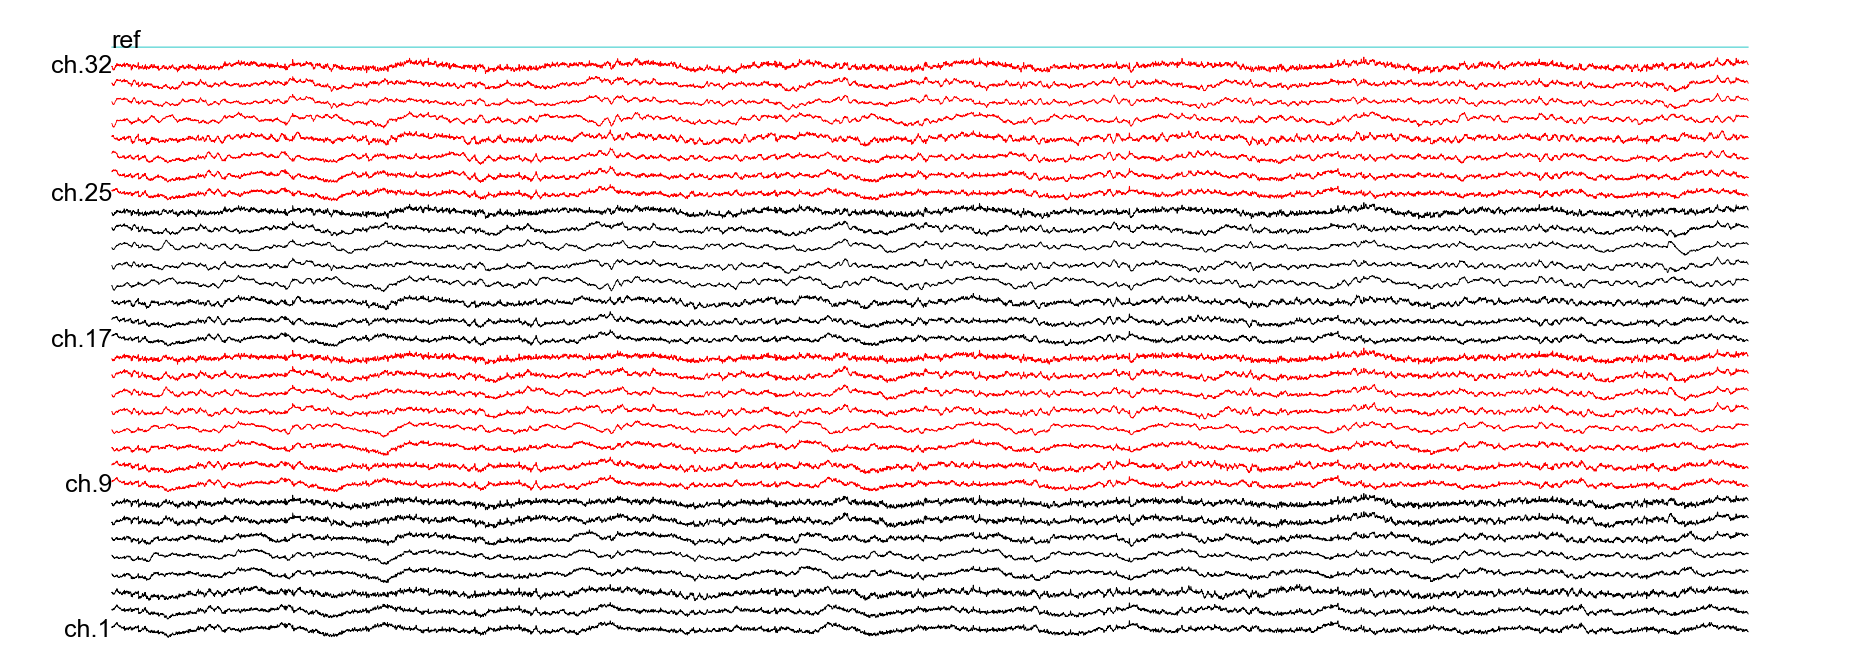

In [37]:
lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'raw_lfp')
downsampled_rate = np.array(5000)
default_sample_rate = np.array(30000)
downsample_factor = default_sample_rate/downsampled_rate
downsample_indicies = np.arange(0,lfp_disk_array.shape[0],downsample_factor,dtype='int')

lfp_disk_array=lfp_disk_array[downsample_indicies,:]
ref = np.expand_dims(np.mean(lfp_disk_array,axis=1),axis=-1)
ref = np.zeros_like(ref)
lfp_disk_array -= ref
plot_sample_wave(lfp_disk_array,downsampled_rate,ref=ref)
update_hdf_data(session_hdf_file, 'downsampled_lfp', lfp_disk_array)
update_hdf_data(session_hdf_file, 'default_sample_rate', default_sample_rate)
update_hdf_data(session_hdf_file, 'downsampled_rate', downsampled_rate)

Loading float16 array shape: (18056293, 32) from HDF5...
Loading complete.
Dataset 'wideband_lfp' 'float16' created with new data.


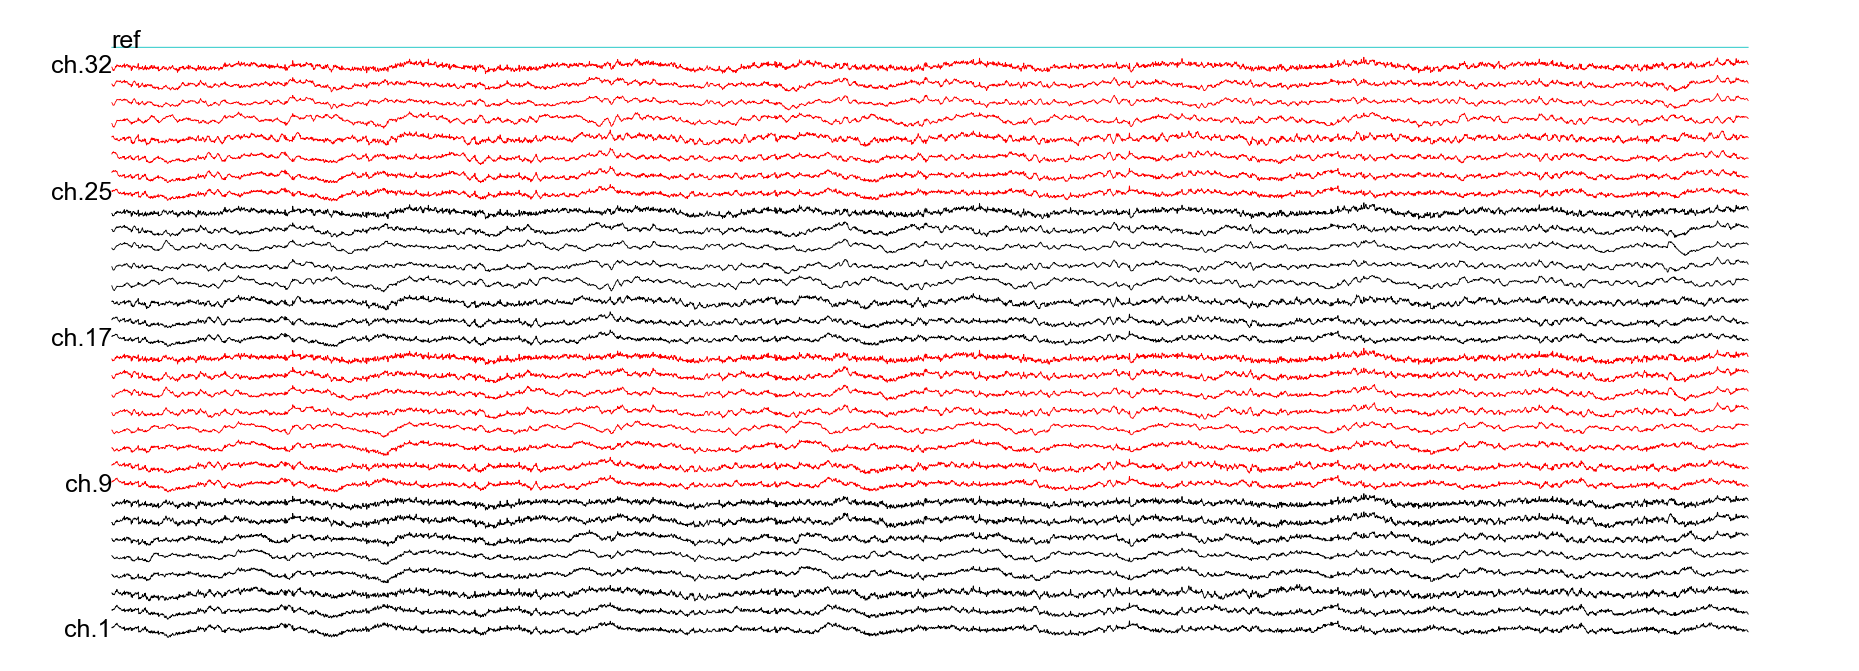

In [39]:
"""
BAND PASS
eta 2m
"""
lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'downsampled_lfp')
nyquist = 0.5 * downsampled_rate
low = 0.1 / nyquist
high = 1000 / nyquist
b, a = sci.signal.butter(2, [low, high], btype='band')
lfp_disk_array = sci.signal.filtfilt(b, a, lfp_disk_array, axis=0).astype('float16')

update_hdf_data(session_hdf_file, 'wideband_lfp', lfp_disk_array)
plot_sample_wave(lfp_disk_array,downsampled_rate,ref=ref)

Loading float16 array shape: (18056293, 32) from HDF5...
Loading complete.
Dataset 'fir_coeff' 'float64' created with new data.
Dataset 'passband' 'int32' created with new data.
Dataset 'ripple_filtered' 'float16' created with new data.


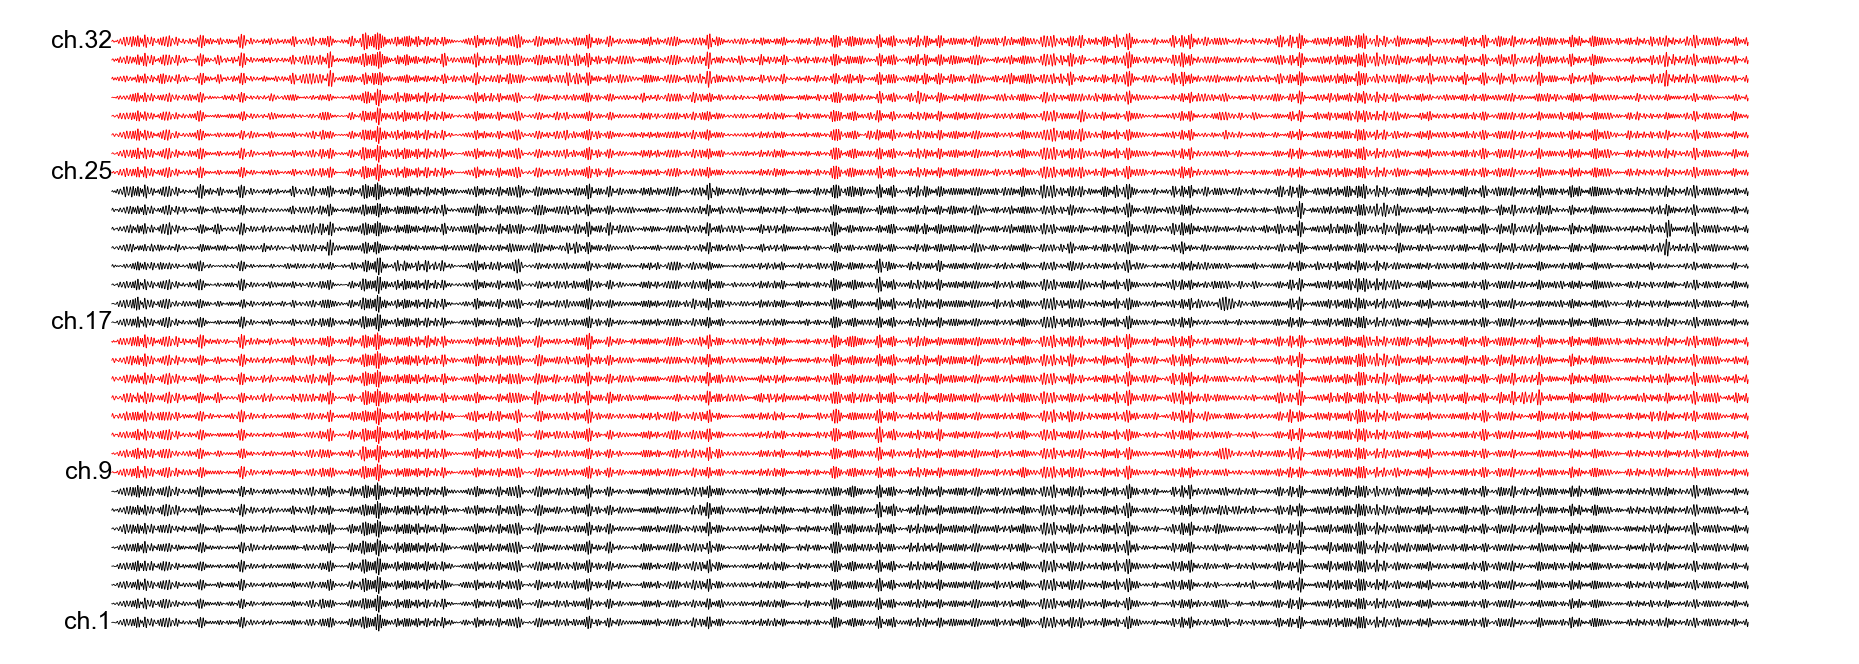

In [40]:
"""
BAND PASS FOR RIPPLES
eta 3m
"""
lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'wideband_lfp')
passband = np.array([150, 250]) #(150-250 Hz)
num_coefficients = 1200
fir_coeff = sci.signal.firwin(num_coefficients, passband, width=10, window='hamming', pass_zero='bandpass', scale=True, fs=float(downsampled_rate))
update_hdf_data(session_hdf_file, 'fir_coeff', fir_coeff)
update_hdf_data(session_hdf_file, 'passband', passband)


''' Apply the FIR filter using filtfilt for zero-phase filtering across all channels '''
lfp_disk_array = sci.signal.filtfilt(fir_coeff, 1.0, lfp_disk_array, axis=0).astype('float16')
update_hdf_data(session_hdf_file, 'ripple_filtered', lfp_disk_array)

plot_sample_wave(lfp_disk_array,downsampled_rate)

In [41]:
session_hdf_file

'\\\\hive.gladstone.internal\\Huang-LFP\\TabuenaLFP\\ReAnalyze\\ZL04_6201_ZL.hdf5'

In [43]:
"""
Hilbert Envelope
eta 3m
"""
lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'ripple_filtered')
downsampled_rate = load_hdf5_to_var(session_hdf_file,'downsampled_rate')
lfp_disk_array = abs(sci.signal.hilbert(lfp_disk_array,axis=0)).astype('float16')
for ch in tqdm(np.arange(lfp_disk_array.shape[1])):
    lfp_disk_array[:,ch] =  abs(sci.signal.hilbert(lfp_disk_array[:,ch])).astype('float16')
update_hdf_data(session_hdf_file, 'hilbert_envelope', lfp_disk_array)
plot_sample_wave(lfp_disk_array,downsampled_rate)

Loading float16 array shape: (18056293, 32) from HDF5...
Loading complete.


MemoryError: Unable to allocate 4.30 GiB for an array with shape (18056293, 32) and data type complex64

In [ ]:
"""
Smoothed
eta 3m
"""
lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'hilbert_envelope')
downsampled_rate = load_hdf5_to_var(session_hdf_file,'downsampled_rate')
lfp_disk_array =  lfp_disk_array.astype('float32')
gauss_width_ms = 4
sigma = gauss_width_ms/1000*downsampled_rate
filter_width_sigmas = 8
num_channels = lfp_disk_array.shape[1]
for c in tqdm(np.arange(num_channels)):
    lfp_disk_array[:,c] = sci.ndimage.gaussian_filter1d(lfp_disk_array[:,c],
                                                sigma, axis=0, mode='reflect',
                                                truncate=filter_width_sigmas)
    lfp_disk_array[:,c] = (lfp_disk_array[:,c] - np.mean(lfp_disk_array[:,c]))/np.std(lfp_disk_array[:,c])
lfp_disk_array =  lfp_disk_array.astype('float16')

update_hdf_data(session_hdf_file, 'smooth_envelope', lfp_disk_array)
plot_sample_wave(lfp_disk_array,downsampled_rate)

In [ ]:
"""
Quantify Ripples
Eta 1m
"""

def find_trace_ripples_df(trace, downsampled_rate, min_thresh_SD=3, min_dur_ms=15, min_gap_ms=4):
    """
    Detects ripple events in a given trace and returns their characteristics as a DataFrame.

    Parameters:
    trace (array-like): The input signal trace in which to detect ripples.
    downsampled_rate (int): The downsampled rate of the signal in Hz.
    min_thresh_SD (float, optional): Minimum threshold for ripple detection in standard deviations (SD). Default is 3 SD.
    min_dur_ms (int, optional): Minimum duration of a ripple event in milliseconds. Default is 15 ms.
    min_gap_ms (int, optional): Minimum gap duration between consecutive ripples in milliseconds. Default is 4 ms.

    Returns:
    pd.DataFrame: A DataFrame containing the start and stop indices of ripples, the index of the maximum value within each ripple, the maximum value of the ripple in SD, and the duration of the ripple in milliseconds.
        - 'starts': Start indices of detected ripples.
        - 'stops': Stop indices of detected ripples.
        - 'max_tic': Indices of the maximum value within each detected ripple.
        - 'ripple_sd_max': Maximum values of the detected ripples in SD.
        - 'duration_ms': Duration of each ripple event in milliseconds.
    """

    # Get all positive/negative threshold crossings
    thresh_crossing = np.diff(trace > min_thresh_SD, prepend=0)
    starts = np.where(thresh_crossing == 1)[0]  # Find the indices where the threshold is crossed from below
    stops = np.where(thresh_crossing == -1)[0]  # Find the indices where the threshold is crossed from above

    if trace[-1] > min_thresh_SD:
        # Drop last ripple if it didn't end
        starts = starts[:-1]


    # Convert minimum duration from milliseconds to samples
    min_dur_tics = int(min_dur_ms / 1000 * downsampled_rate)
    # Ensure ripple duration is greater than the minimum duration
    valid_durations = (stops - starts) >= min_dur_tics
    starts = starts[valid_durations]
    stops = stops[valid_durations]


    # Calculate the minimum gap duration in ticks (samples)
    min_gap_tics = int(min_gap_ms / 1000 * downsampled_rate)
    # Calculate the duration of gaps between consecutive ripples
    gap_dur = starts[1:] - stops[:-1]
    # Identify gaps that are longer than the minimum gap duration
    gaps_to_keep = gap_dur > min_gap_tics
    # Keep only the ripple start indices that follow a sufficient gap
    starts = starts[np.insert(gaps_to_keep, 0, True)]
    # Keep only the ripple stop indices that precede a sufficient gap
    stops = stops[np.insert(gaps_to_keep, -1, True)]




    # Initialize arrays to store the maximum values and their indices within each ripple
    ripple_sd_max = np.zeros_like(starts).astype('float')
    max_tic = np.zeros_like(starts)
    # Iterate over each detected ripple to find the maximum value and its index
    for rip, (tic_on, tic_off) in enumerate(zip(starts, stops)):
        max_tic[rip] = np.argmax(trace[tic_on:tic_off]) + tic_on  # Adjust index to the correct position in the trace
        ripple_sd_max[rip] = trace[max_tic[rip]]

    # Calculate the duration of each ripple in milliseconds
    duration_ms = (stops - starts) / downsampled_rate * 1000

    # Create a DataFrame to store the ripple characteristics
    channel_ripples_df = pd.DataFrame({
        'starts': starts,
        'stops': stops,
        'max_tic': max_tic,
        'ripple_sd_max': ripple_sd_max,
        'duration_ms': duration_ms
    })

    return channel_ripples_df


lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'smooth_envelope')
# downsampled_rate = load_hdf5_to_memmap(session_hdf_file, 'downsampled_rate')
plot_sample_wave(lfp_disk_array,downsampled_rate)
ripple_df_list = [find_trace_ripples_df(lfp_disk_array[:,ch],downsampled_rate) for ch in np.arange(lfp_disk_array.shape[1])]


# fig,ax = rip_hist(ripple_df_list)
# sd_count = [np.sum(df['ripple_sd_max']>5) for df in ripple_df_list]
fig,ax = plt.subplots(figsize=(4,1.5))
ch = np.arange(32)
ax.plot(ch, [np.sum(df['ripple_sd_max']>3) for df in ripple_df_list],label='3sd')
ax.plot(ch, [np.sum(df['ripple_sd_max']>5) for df in ripple_df_list],label='5sd')
ax.plot(ch, [np.sum(df['ripple_sd_max']>7) for df in ripple_df_list],label='7sd')
ax.set_xlabel('Channel')
ax.set_ylabel('Ripple Count')
_, max_y = ax.get_ylim()
ax.set_ylim(0, max_y)
plt.legend()

In [ ]:
update_hdf_data(session_hdf_file, 'downsampled_rate', downsampled_rate)

In [ ]:
print(lfp_disk_array.shape)

In [ ]:
downsampled_rate

In [ ]:
# trace_len = lfp_disk_array.shape[0]
# other_trace_len = 12637483
# print(trace_len/downsampled_rate/60,'minutes')

delta_tic = trace_len - other_trace_len
delta_sec = delta_tic / downsampled_rate
delta_min = delta_sec / 60
